## MNIST

In [1]:
import torch
import numpy as np

### Load and Visualize the Dataset

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib

In [8]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms

In [15]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize a Batch of Training Data

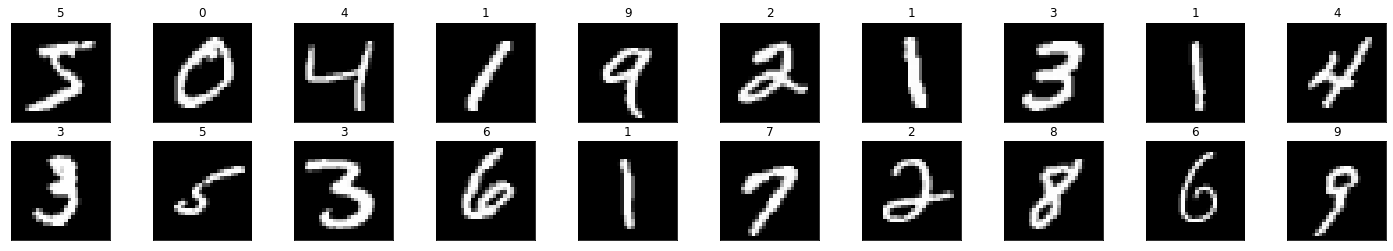

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### Define the Network Architecture 

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 784)
        
        # add hiden layer with relu activation  function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x

In [38]:
# initialize the NN
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#### Specify Loss Function and Optimizer

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

#### Traini the Network

In [40]:
epochs = 20

model.train()

for epoch in range(epochs):
    train_loss = 0.
    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(trainloader.dataset)
    print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.3f}')

Epoch: 1 	Training Loss: 0.434
Epoch: 2 	Training Loss: 0.274
Epoch: 3 	Training Loss: 0.233
Epoch: 4 	Training Loss: 0.219
Epoch: 5 	Training Loss: 0.198
Epoch: 6 	Training Loss: 0.192
Epoch: 7 	Training Loss: 0.183
Epoch: 8 	Training Loss: 0.173
Epoch: 9 	Training Loss: 0.167
Epoch: 10 	Training Loss: 0.163
Epoch: 11 	Training Loss: 0.160
Epoch: 12 	Training Loss: 0.153
Epoch: 13 	Training Loss: 0.151
Epoch: 14 	Training Loss: 0.147
Epoch: 15 	Training Loss: 0.140
Epoch: 16 	Training Loss: 0.140
Epoch: 17 	Training Loss: 0.144
Epoch: 18 	Training Loss: 0.137
Epoch: 19 	Training Loss: 0.139
Epoch: 20 	Training Loss: 0.132


#### Test the Trained Network

In [46]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(images)
    # calculate the loss
    loss = criterion(outputs, labels)
    # update test loss
    test_loss += loss.item() * images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(outputs, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    # calculate  test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(testloader.dataset)
print(f'Test Loss: {test_loss:.3f}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}: {100 * class_correct[i] / class_total[i]} ({class_correct[i]}/{class_total[i]})')
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.137

Test Accuracy of 0: 99.38775510204081 (974.0/980.0)
Test Accuracy of 1: 98.8546255506608 (1122.0/1135.0)
Test Accuracy of 2: 97.38372093023256 (1005.0/1032.0)
Test Accuracy of 3: 97.92079207920793 (989.0/1010.0)
Test Accuracy of 4: 97.75967413441956 (960.0/982.0)
Test Accuracy of 5: 97.19730941704036 (867.0/892.0)
Test Accuracy of 6: 97.18162839248434 (931.0/958.0)
Test Accuracy of 7: 97.76264591439688 (1005.0/1028.0)
Test Accuracy of 8: 95.89322381930185 (934.0/974.0)
Test Accuracy of 9: 96.72943508424183 (976.0/1009.0)

Test Accuracy (Overall): 97% (9763/10000)


#### Visualize Sample Test Results

In [49]:
# obtain one batch of test images
dataiter= iter(testloader)
images, labels = dataiter.next()

# get sample outputs
outputs = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(otuputs, 1)

# preprcess images for display
images = images.numpy()

# plot the images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

NameError: name 'otuputs' is not defined